In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numba

%matplotlib widget

#### Functions

In [2]:
def init_conf_fcc(num_particles, rho, dtype=np.float32):
    
    # define number of spatial dimensions
    D = 3
    
    # calculate the minimum number of cells along each dimension
    cell_per_dim = int(np.ceil((num_particles/4)**(1 / D)))

    # initiallize array of lattice sites
    sites = np.zeros((4*cell_per_dim**D, D), dtype=dtype)

    # loop over cells and generate lattice sites
    count = 0 
    for x in range(cell_per_dim):
        for y in range(cell_per_dim):
            for z in range(cell_per_dim):
                sites[count+0,:] = [x+0.25, y+0.25, z+0.25]
                sites[count+1,:] = [x+0.75, y+0.75, z+0.25]
                sites[count+2,:] = [x+0.75, y+0.25, z+0.75]
                sites[count+3,:] = [x+0.25, y+0.75, z+0.75]
                count += 4

    # center box on the origin
    for k in range(D):
        sites[:,k] -= np.mean(sites[:,k]) 

    # fill sites radially by distance from origin
    conf = sites[np.argsort(np.linalg.norm(sites, axis=1))]
    conf = conf[:num_particles]

    # get density scaling factor
    rho_initial = num_particles / cell_per_dim**D
    scale_factor = dtype((rho_initial/rho)**(1/D))

    # make sim box array
    sim_box = np.array([cell_per_dim]*3, dtype=dtype)

    # adjust density and return final arrays
    return conf*scale_factor, sim_box*scale_factor

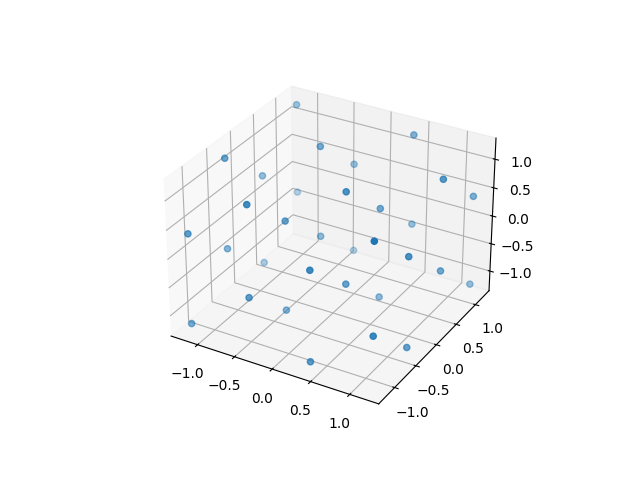

In [3]:
N = 32
rho = 1

xyz, box = init_conf_fcc(N, rho)
fig = plt.figure()
ax = plt.axes(projection ="3d")

x, y, z = xyz.T
ax.scatter3D(x,y,z)
plt.show()

In [4]:
def generate_random_velocities(N, T, D=3, dtype=np.float32):
    v = dtype(np.random.normal(0.0, (T)**0.5, (N,D)))    ###### Assuming m=1, ######
    for k in range(D):
        v[:,k] -= np.mean(v[:,k]) # remove drift
    return v


@numba.njit
def pot_LJ(r, eps=1, sigma=1):
    pot = 4*eps*((sigma/r)**12 - (sigma/r)**6)
    return pot


@numba.njit
def calculate_distance(atom1, atom2):
    dx = atom2[0] - atom1[0]
    dy = atom2[1] - atom1[1]
    dz = atom2[2] - atom1[2]

    r = (dx**2 + dy**2 + dz**2) ** 0.5

    return r


@numba.njit
def calculate_force(r, eps, sigma):
    return 48*eps*(sigma**12/r**13 - 0.5*(sigma**6/r**7))


@numba.njit(parallel=True)
def calculate_U_and_F(conf, LJ_params, dtype=np.float32):
    U = 0
    N = len(conf)
    F = np.zeros_like(conf)
    for i in range(N-1):
        for j in range(i + 1, N):
            r_i = conf[i]
            r_j = conf[j]
            r_ij = r_j - r_i
            
            # calculate energy
            r = calculate_distance(r_i, r_j)
            e = pot_LJ(r, *LJ_params)
            U += e

            # calculate force
            F_ij = (r_ij / r) * calculate_force(r, *LJ_params)
            F[i] += F_ij
            F[j] -= F_ij
    
    return U, F
    

@numba.njit
def run(conf_initial, dt, n_steps, v_i, m, LJ_params, dtype=np.float32):
    
    conf_all = np.zeros((n_steps+1, *conf_initial.shape))
    conf_all[0] = conf_initial
    
    U_total = np.zeros(n_steps+1)
    K_total = np.zeros(n_steps+1)

    v = v_i

    U_total[0], F = calculate_U_and_F(conf_all[0], LJ_params)
    K_total[0] = np.sum(0.5*m*v**2)

    for step in range(n_steps):
        a = F/m
        v_half = v + a*dt/2
        conf_all[step+1] = conf_all[step] + v_half*dt
        
        U_total[step+1], F = calculate_U_and_F(conf_all[step+1], LJ_params)
        
        a_1 = F/m
        v_1 = v_half + a_1*dt/2

        a = a_1
        v = v_1

        K_total[step+1] = np.sum(0.5*m*v**2)

    return U_total, K_total, conf_all
    


In [5]:
N = 32
rho = 0.5

conf_initial, box = init_conf_fcc(N, rho)

dt = 0.001
n_steps = 100
T = 1

v_i = generate_random_velocities(N, T).astype(np.float64)
m = 1
eps = 1
sigma = 1
LJ_params = (eps, sigma)

conf_initial = conf_initial.astype(np.float64)

U, K, confs = run(conf_initial, dt, n_steps, v_i, m, LJ_params)


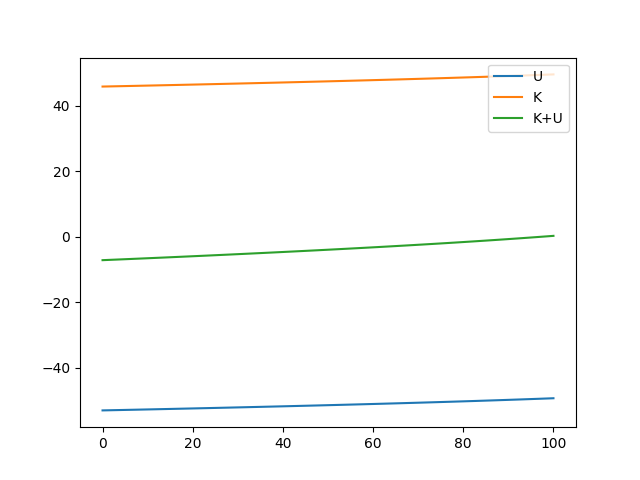

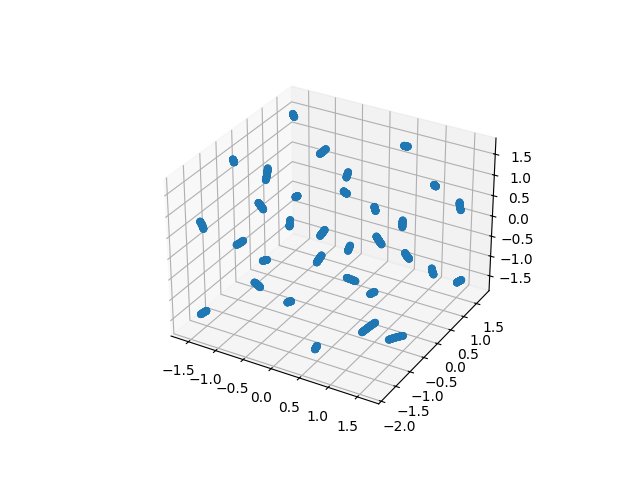

In [6]:
plt.figure()
plt.plot(U, label="U")
plt.plot(K, label="K")
plt.plot(K+U, label="K+U")
plt.legend()
plt.show()

fig = plt.figure()
ax = plt.axes(projection ="3d")
x, y, z = confs.T
ax.scatter(x,y,z)
plt.show()

In [7]:
confs


array([[[ 0.5       ,  0.5       ,  0.5       ],
        [-0.5       , -0.5       ,  0.5       ],
        [ 0.5       , -0.5       , -0.5       ],
        ...,
        [ 1.5       , -1.5       ,  1.5       ],
        [ 1.5       ,  1.5       , -1.5       ],
        [-1.5       ,  1.5       ,  1.5       ]],

       [[ 0.49966169,  0.50016348,  0.50082723],
        [-0.50011095, -0.50003293,  0.49833408],
        [ 0.50137341, -0.49956339, -0.50053742],
        ...,
        [ 1.50116173, -1.50071955,  1.49908092],
        [ 1.50042388,  1.50052073, -1.49936763],
        [-1.49960878,  1.49882664,  1.50129858]],

       [[ 0.49932374,  0.50032731,  0.50165481],
        [-0.50022226, -0.5000662 ,  0.49666855],
        [ 0.50274716, -0.49912714, -0.50107521],
        ...,
        [ 1.50232602, -1.50144165,  1.49816438],
        [ 1.50085031,  1.50104402, -1.49873782],
        [-1.49922012,  1.49765584,  1.50259973]],

       ...,

       [[ 0.46954815,  0.51634731,  0.58183159],
        [-0